In [60]:
import pandas as pd
import matplotlib.pyplot as plt #graphique
import json
import os

## Lecture du csv

In [61]:
file_path = '/media/tessier/FORMATE/ph-db.csv'
separator = ';'
data = pd.read_csv(file_path, delimiter=';', encoding='utf-8')
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

## Convertion du temps

In [62]:
def convert_times(seconds):
    if seconds < 60:
        return f"{seconds} secondes"
    elif seconds < 3600:
        minutes = seconds / 60
        return f"{minutes:.2f} minutes"
    else:
        hours = seconds / 3600
        return f"{hours:.2f} heures"

## Graphique Top et Bottom

In [63]:
def graph_top_bottom(_video_name, _value, _x_name, _metric, _num_top, _top_or_bottom):
    plt.figure(figsize=(10, 5), facecolor='#000000')  # taille graph 10 pouces et 5 pouces de large, fond noir

    ax = plt.gca()  #personnaliser le fond
    ax.set_facecolor('#000000') #fond noir

    ax.bar(_video_name, _value, color='#f79817') #valeur et nom video en orange
    ax.set_xlabel('Vidéos', color='#ffffff')  # nom de l'axe x en blanc
    ax.set_ylabel(f'Nombre de {_metric}', color='#ffffff')  #nom de l'axe y en blanc

    if _x_name == None:
        ax.set_title(f'{_top_or_bottom} {_num_top} {_metric}', color='#ffffff')  #titre du graphique en blanc
    else:
        ax.set_title(f'{_top_or_bottom} {_num_top} {_x_name}', color='#ffffff')  #titre du graphique en blanc

    ax.tick_params(axis='x', colors='#ffffff')  #contour x en blanc
    ax.tick_params(axis='y', colors='#ffffff')  #contour y en blanc
    ax.spines['bottom'].set_color('#ffffff') 
    ax.spines['top'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    ax.spines['right'].set_color('#ffffff')

    plt.xticks(rotation=90, ha='right') #affichage video sur graphique
    plt.tight_layout() #ameliorer rendu visuel
    plt.show() #afficher graphique

    tab = []
    for i, (video, metrics) in enumerate(zip(_video_name, _value), start=1):
        if _metric == 'times':
            print(f"{i}: {metrics} secondes - title: {video}")
        else:
            print(f"{i}: {metrics} {_metric} - title: {video}")

        if _x_name == None:
            if _metric == 'Times':
                info = {"rank": i, "title": video, "metric": _metric, f"Secondes_value": metrics}
            else:
                info = {"rank": i, "title": video, "metric": _metric, f"{_metric}_value": metrics}
        else :
            if _metric == 'Times':
                info = {"rank": i, "title": video, "metric": _metric, f"Secondes_{_x_name}_value": metrics}
            else:
                info = {"rank": i, "title": video, "metric": _metric, f"{_metric}_{_x_name}_value": metrics}
        tab.append(info)

    if _top_or_bottom == 'top':
        if not os.path.exists('JSON_top'):
            os.makedirs('JSON_top')
        if _x_name == None:
            JSON_top = f'JSON_top/JSON_top_{_num_top}_{_metric}.json'
        else:
            JSON_top = f'JSON_top/JSON_top_{_num_top}_{_metric}_{_x_name}.json'
        with open(JSON_top, 'w', encoding='utf-8') as f:
            json.dump(tab, f, ensure_ascii=False, indent=4)
        print(f"chemin vers fichier JSON : {JSON_top}")

    elif _top_or_bottom == 'bottom':
        if not os.path.exists('JSON_bottom'):
            os.makedirs('JSON_bottom')
        if _x_name == None:
            JSON_bottom = f'JSON_bottom/JSON_bottom_{_num_top}_{_metric}.json'
        else:
            JSON_bottom = f'JSON_bottom/JSON_bottom_{_num_top}_{_metric}_{_x_name}.json'
        with open(JSON_bottom, 'w', encoding='utf-8') as f:
            json.dump(tab, f, ensure_ascii=False, indent=4)
        print(f"chemin vers fichier JSON : {JSON_bottom}")

## Gestion de top
Entrez "top views/likes/dislikes/times/categories/tags number/pornstars/categories (si number entrez /pornstars/categories) entrez name_pornstar or name_categories" et le top apparaitra!

In [64]:
def get_top(data, metric, num, filter_col=None, filter_val=None):
    if filter_col and filter_val:
        data = data[data[filter_col].str.contains(filter_val, case=False, na=False)]
    # metric = 'categories', 'tags', other..; num = nombre d'element à extraire filter_col = pornstars/categories filter_val = nom_entré
    if metric == 'categories':
        total_categories = data['categories'].str.split(separator).explode().str.strip().nunique()
        if num > total_categories:
            print(f"Le nombre demandé dépasse le nombre de catégories disponibles. Affichage des {total_categories} meilleures catégories à la place.")
            num = total_categories
        top_categories = data['categories'].str.split(separator).explode().str.strip().value_counts().nlargest(num)
        graph_top_bottom(top_categories.index, top_categories.values, 'Catégories', filter_val, num, 'top')
    elif metric == 'tags':
        total_tags = data['tags'].str.split(separator).explode().str.strip().nunique()
        if num > total_tags:
            print(f"Le nombre demandé dépasse le nombre de tags disponibles. Affichage des {total_tags} meilleurs tags à la place.")
            num = total_tags
        top_tags = data['tags'].str.split(separator).explode().str.strip().value_counts().nlargest(num)
        graph_top_bottom(top_tags.index, top_tags.values, 'Tags', filter_val, num, 'top')
    else: #les autres categories n'ont qu'une seule valeur
        total_items = len(data)
        if num > total_items:
            print(f"Le nombre demandé dépasse le nombre d'éléments disponibles. Affichage des {total_items} meilleurs éléments à la place.")
            num = total_items
        top_items = data.nlargest(num, metric)[['title', metric]]
        graph_top_bottom(top_items['title'], top_items[metric], filter_val, metric.capitalize(), num, 'top')

## Gestion de bottom (le top inversé)
Entrez "bottom views/likes/dislikes/times/categories/tags puis number_of_top/pornstars/categories (si number entrez /pornstars/categories) puis entrez name_pornstar or name_categories" et le top des PIRES apparaitra!

In [65]:
def get_bottom(data, metric, num, filter_col=None, filter_val=None):
    if filter_col and filter_val:
        data = data[data[filter_col].str.contains(filter_val, case=False, na=False)]
    # metric = 'categories', 'tags', other..; num = nombre d'element à extraire; filter_col = pornstars/categories; filter_val = nom_entré
    if metric == 'categories':
        total_categories = data['categories'].str.split(separator).explode().str.strip().nunique()
        if num > total_categories:
            print(f"Le nombre demandé dépasse le nombre de catégories disponibles. Affichage des {total_categories} moins bonnes catégories à la place.")
            num = total_categories
        bottom_categories = data['categories'].str.split(separator).explode().str.strip().value_counts().nsmallest(num)
        graph_top_bottom(bottom_categories.index, bottom_categories.values, 'Catégories', filter_val, num, 'bottom')
    elif metric == 'tags':
        total_tags = data['tags'].str.split(separator).explode().str.strip().nunique()
        if num > total_tags:
            print(f"Le nombre demandé dépasse le nombre de tags disponibles. Affichage des {total_tags} moins bons tags à la place.")
            num = total_tags
        bottom_tags = data['tags'].str.split(separator).explode().str.strip().value_counts().nsmallest(num)
        graph_top_bottom(bottom_tags.index, bottom_tags.values, 'Tags', filter_val, num, 'bottom')
    else:
        total_items = len(data)
        if num > total_items:
            print(f"Le nombre demandé dépasse le nombre d'éléments disponibles. Affichage des {total_items} moins bons éléments à la place.")
            num = total_items
        bottom_items = data.nsmallest(num, metric)[['title', metric]]
        graph_top_bottom(bottom_items['title'], bottom_items[metric], filter_val, metric.capitalize(), num, 'bottom')

## Calculer une moyenne
Entrez "average views/likes/dislikes/times puis pornstars/categories puis name_pornstars or name_categories" et vous aurez la moyenne!

In [66]:
def get_average(data, metric, filter_col=None, filter_val=None):
    if filter_col and filter_val:
        if filter_col in data.select_dtypes(include=['object']).columns:
            data = data[data[filter_col].str.contains(filter_val, case=False, na=False)]
        else:
            print(f"Impossible d'appliquer un filtre sur la colonne '{filter_col}' car elle n'est pas de type chaîne.")
            return
    # metric = 'categories', 'tags', other..; filter_col = pornstars/categories; filter_val = nom_entré
    average_metric = data[metric].mean() #calcul moyenne
    if metric == 'times':
        average_metric_converted = convert_times(average_metric)
        print(f'La moyenne de {metric.capitalize()} pour {filter_val} est : {average_metric_converted}')
    else:
        print(f'La moyenne de {metric.capitalize()} pour {filter_val} est : {average_metric}')

## Lien d'une video
Entrez "src name_title" et vous aurez la source de la vidéo qui apparaitra!

In [67]:
def get_src(data, video_name):
    row = data[data['title'].str.contains(video_name, case=False, na=False)]
    if not row.empty:
        print(f"{video_name}: {row.iloc[0]['src']}")
        return True
    else:
        print(f"La vidéo '{video_name}' n'existe pas.")
        return False

## Obtenir la globalité (en nombre) d'une categorie, d'un tag ou d'une actrice
Entrez "count categories/pornstars puis name_categories/name_pornstars"

In [68]:
def count_items(data, item_type, item_name):
    if item_type == 'categories':
        count = data[data['categories'].str.contains(item_name, case=False, na=False)].shape[0]
        print(f"Le nombre de vidéos avec la catégorie '{item_name}' est : {count}")
    elif item_type == 'tags':
        count = data[data['tags'].str.contains(item_name, case=False, na=False)].shape[0]
        print(f"Le nombre de vidéos avec le tag '{item_name}' est : {count}")
    elif item_type == 'pornstars':
        count = data[data['pornstars'].str.contains(item_name, case=False, na=False)].shape[0]
        print(f"Le nombre de vidéos avec la pornstar '{item_name}' est : {count}")
    else:
        print(f"Type d'élément '{item_type}' invalide pour le comptage.")

## Obtenir toutes les informations d'une video (actrice, année, lien, likes , etc.)
Entrez "infos name_video" et vous aurez toutes les infos, 'enjoy' comme on dit!

In [69]:
def get_infos(data, video_name):
    row = data[data['title'].str.contains(video_name, case=False, na=False)]
    if not row.empty:
        print(f"Informations pour '{video_name}':")
        row_data = row.iloc[0].copy()
        row_data['times'] = convert_times(row_data['times'])
        print(row_data)
        return True
    else:
        print(f"La vidéo '{video_name}' n'existe pas.")
        return False

## Classement des pornstars
Entrez "pornstars likes/dislikes/views/categories/tags/times puis number_of_pornstars (si categories/tags name_categories)"

In [70]:
def process_chunk(chunk, metric, filter_val=None):
    if filter_val and metric in ['tags', 'categories']:
        chunk = chunk[chunk[metric].str.contains(filter_val, case=False, na=False)]

    chunk = chunk.dropna(subset=['pornstars', metric])
    chunk_expanded = chunk.assign(pornstars=chunk['pornstars'].str.split(';')).explode('pornstars')
    chunk_expanded['pornstars'] = chunk_expanded['pornstars'].str.strip()

    if metric in ['tags', 'categories']:
        chunk_expanded = chunk_expanded.explode(metric)
        chunk_expanded[metric] = chunk_expanded[metric].str.strip()
        grouped_chunk = chunk_expanded.groupby('pornstars')[metric].count()
    else:
        grouped_chunk = chunk_expanded.groupby('pornstars')[metric].sum()

    return grouped_chunk

def pornstars_stats(data, metric, num_results, filter_val=None):
    result = pd.Series(dtype='float64')
    total_rows = len(data)
    chunksize = 500000
    n_chunks = (total_rows // chunksize) + 1 if total_rows % chunksize != 0 else total_rows // chunksize

    num_results = int(num_results)
    
    for i in range(n_chunks):
        chunk = data.iloc[i*chunksize:(i+1)*chunksize]
        chunk_result = process_chunk(chunk, metric, filter_val)
        result = result.add(chunk_result, fill_value=0)

    result = result.sort_values(ascending=False)

    display_result = result.head(num_results)
    plt.figure(figsize=(10, max(5, len(display_result) / 2)), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')

    max_val = display_result.max()

    ax.barh(display_result.index[::-1], display_result.values[::-1], color='#f79817')  # Inverser l'ordre des valeurs
    ax.set_xlim(0, max_val)

    if metric == 'categories' or metric == 'tags':
        ax.set_xlabel(f'Nombre de {metric} {filter_val}', color='white')
    else:
        ax.set_xlabel(f'Nombre de {metric}', color='white')

    ax.set_ylabel('Pornstars', color='white')

    if metric == 'categories' or metric == 'tags':
        ax.set_title(f'Statistiques des Pornstars par {metric} {filter_val}', color='white')
    else:
        ax.set_title(f'Statistiques des Pornstars par {metric.capitalize()}', color='white')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')

    plt.tight_layout()
    plt.show()

    tab_pornstars = []
    for i, (acteur, nb_metric) in enumerate(zip(display_result.index, display_result.values), start=1):
        if metric in ['categories', 'tags']:
            print(f"{i}: {nb_metric} {metric} {filter_val} - pornstars: {acteur}")
            info = {"rank": i, "value": nb_metric, "metric": metric, "metric_categories": filter_val, "pornstars": acteur}
            tab_pornstars.append(info)
        else:
            print(f"{i}: {nb_metric} {metric} - pornstars: {acteur}")
            info = {"rank": i, "value": nb_metric, "metric": metric, "pornstars": acteur}
            tab_pornstars.append(info)

    if metric in ['categories', 'tags']:
        JSON_pornstars = f'JSON_pornstars/JSON_pornstars_{filter_val}_{metric}_top_{num_results}.json'
        if not os.path.exists('JSON_pornstars'):
            os.makedirs('JSON_pornstars')
        with open(JSON_pornstars, 'w', encoding='utf-8') as f:
            json.dump(tab_pornstars, f, ensure_ascii=False, indent=5)
    else:
        JSON_pornstars = f'JSON_pornstars/JSON_pornstars_{metric}_top_{num_results}.json'
        if not os.path.exists('JSON_pornstars'):
            os.makedirs('JSON_pornstars')
        with open(JSON_pornstars, 'w', encoding='utf-8') as f:
            json.dump(tab_pornstars, f, ensure_ascii=False, indent=4)
    
    print(f"chemin vers fichier JSON : {JSON_pornstars}")

## Gestion de l'evolution
Permet de conaitre l'evolution d'une categorie ou des videos sur des années/mois/semaines. 

In [71]:
def plot_evolution(data, period, start_date, end_date=None, metric=None, top_n=None):
    current_date = pd.Timestamp.now()

    if not isinstance(start_date, pd.Timestamp):
        if start_date.isdigit() or start_date == "all":
            num_periods = int(start_date) if start_date.isdigit() else None
            if num_periods:
                if period == 'year':
                    start_date = current_date - pd.DateOffset(years=num_periods)
                elif period == 'month':
                    start_date = current_date - pd.DateOffset(months=num_periods)
                elif period == 'week':
                    start_date = current_date - pd.DateOffset(weeks=num_periods)
            end_date = current_date
        else:
            try:
                start_date = pd.to_datetime(start_date, format='%d/%m/%Y')
            except ValueError:
                start_date = pd.to_datetime(start_date, format='%Y')
            
            if end_date and end_date != "all" and not end_date.isdigit():
                try:
                    end_date = pd.to_datetime(end_date, format='%d/%m/%Y')
                except ValueError:
                    end_date = pd.to_datetime(end_date, format='%Y')
                end_date = end_date.replace(month=12, day=31)
            else:
                end_date = current_date

    if metric in ['categories', 'tags', 'pornstars']:
        data_expanded = data.dropna(subset=[metric]).copy()
        data_expanded[metric] = data_expanded[metric].str.split(separator).explode().str.strip().reset_index(drop=True)
        data_expanded['year'] = pd.to_datetime(data_expanded['date']).dt.year

        filtered_data = data_expanded[(pd.to_datetime(data_expanded['date']) >= start_date) & (pd.to_datetime(data_expanded['date']) <= end_date)]
        grouped_metric_data = filtered_data.groupby(['year', metric]).size().unstack(fill_value=0)

        if top_n:
            top_metrics = grouped_metric_data.sum().nlargest(int(top_n)).index
            grouped_metric_data = grouped_metric_data[top_metrics]


        fig, ax = plt.subplots(figsize=(12, 8), facecolor='#000000')
        ax.set_facecolor('#000000')
        width = 0.2  # Width of the bars
        positions = list(range(len(grouped_metric_data.index)))

        colors = ['#f79817', '#87CEEB', '#FF6347', '#32CD32', '#FFD700', '#1E90FF', '#DA70D6']

        for i, (metric_name, color) in enumerate(zip(grouped_metric_data.columns, colors)):
            ax.bar(
                [p + width * i for p in positions],
                grouped_metric_data[metric_name],
                width=width,
                label=metric_name,
                color=color
            )

        ax.set_xlabel('Année', color='#ffffff')
        ax.set_ylabel('Nombre de vidéos', color='#ffffff')
        ax.set_title(f'Évolution des {metric} les plus populaires par année', color='#ffffff')
        ax.set_xticks([p + width * (len(grouped_metric_data.columns) / 2) for p in positions])
        ax.set_xticklabels(grouped_metric_data.index.astype(int))
        ax.tick_params(axis='x', colors='#ffffff')
        ax.tick_params(axis='y', colors='#ffffff')
        ax.spines['bottom'].set_color('#ffffff')
        ax.spines['top'].set_color('#ffffff')
        ax.spines['left'].set_color('#ffffff')
        ax.spines['right'].set_color('#ffffff')
        plt.xticks(rotation=45)

        ax.legend(title=metric, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        tab = []
        for year, metrics in grouped_metric_data.iterrows():
            for metric_name, value in metrics.items():
                info = {
                    "year": year,
                    "metric": metric,
                    "metric_name": metric_name,
                    "value": value
                }
                tab.append(info)

        folder = 'JSON_evolution'
        if not os.path.exists(folder):
            os.makedirs(folder)
        JSON_file = f'{folder}/evolution_{metric}_top_{top_n}_years.json'
        with open(JSON_file, 'w', encoding='utf-8') as f:
            json.dump(tab, f, ensure_ascii=False, indent=4)
        print(f"chemin vers fichier JSON : {JSON_file}")

    else:
        if period == 'year':
            data['year'] = pd.to_datetime(data['date']).dt.year
            filtered_data = data[(pd.to_datetime(data['date']) >= start_date) & (pd.to_datetime(data['date']) <= end_date)]
            grouped_data = filtered_data.groupby('year').size().reindex(range(start_date.year, end_date.year + 1), fill_value=0).reset_index(name='count')
            fig, ax = plt.subplots(figsize=(10, 5), facecolor='#000000')
            ax.set_facecolor('#000000')
            ax.plot(grouped_data['year'], grouped_data['count'], marker='o', color='#f79817')
        elif period == 'month':
            data['year_month'] = pd.to_datetime(data['date']).dt.to_period('M')
            filtered_data = data[(pd.to_datetime(data['date']) >= start_date) & (pd.to_datetime(data['date']) <= end_date)]
            grouped_data = filtered_data.groupby('year_month').size().reset_index(name='count')
            date_range = pd.period_range(start=start_date.to_period('M'), end=end_date.to_period('M'), freq='M')
            grouped_data = grouped_data.set_index('year_month').reindex(date_range, fill_value=0).reset_index()
            grouped_data['year_month'] = grouped_data['index'].astype(str)
            grouped_data.drop(columns='index', inplace=True)
            fig, ax = plt.subplots(figsize=(10, 5), facecolor='#000000')
            ax.set_facecolor('#000000')
            ax.plot(grouped_data['year_month'], grouped_data['count'], marker='o', color='#f79817')
        elif period == 'week':
            data['year_week'] = pd.to_datetime(data['date']).dt.to_period('W')
            filtered_data = data[(pd.to_datetime(data['date']) >= start_date) & (pd.to_datetime(data['date']) <= end_date)]
            grouped_data = filtered_data.groupby('year_week').size().reset_index(name='count')
            date_range = pd.period_range(start=start_date.to_period('W'), end=end_date.to_period('W'), freq='W')
            grouped_data = grouped_data.set_index('year_week').reindex(date_range, fill_value=0).reset_index()
            grouped_data['year_week'] = grouped_data['index'].astype(str)
            grouped_data.drop(columns='index', inplace=True)
            fig, ax = plt.subplots(figsize=(10, 5), facecolor='#000000')
            ax.set_facecolor('#000000')
            ax.plot(grouped_data['year_week'], grouped_data['count'], marker='o', color='#f79817')

        ax.set_xlabel('Année' if period == 'year' else 'Période', color='#ffffff')
        ax.set_ylabel('Nombre de vidéos publiées', color='#ffffff')
        ax.set_title(f'Évolution du nombre de vidéos publiées par {period}', color='#ffffff')
        ax.tick_params(axis='x', colors='#ffffff')
        ax.tick_params(axis='y', colors='#ffffff')
        ax.spines['bottom'].set_color('#ffffff')
        ax.spines['top'].set_color('#ffffff')
        ax.spines['left'].set_color('#ffffff')
        ax.spines['right'].set_color('#ffffff')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        tab = grouped_data.to_dict(orient='records')
        folder = 'JSON_evolution'
        if not os.path.exists(folder):
            os.makedirs(folder)
        JSON_file = f'{folder}/evolution_{period}_videos_periods.json'
        with open(JSON_file, 'w', encoding='utf-8') as f:
            json.dump(tab, f, ensure_ascii=False, indent=4)
        print(f"chemin vers fichier JSON : {JSON_file}")


## Analyse de la commande Input
Analyse la commande et appel la fonction pouvant gérer cette methode.

In [72]:
def process_input(input_str):
    parts = input_str.split()
    
    if len(parts) == 0:
        print("Aucune entrée fournie. Veuillez entrer une requête valide.")
        return

    category, metric, value, filter_col, filter_val = None, None, None, None, None
    
    if parts[0] == 'count' and len(parts) > 2:
        category = parts[0]
        metric = parts[1]
        filter_val = ' '.join(parts[2:])
        filter_col = metric
        value = None
    elif len(parts) >= 2:
        category = parts[0]
        metric = parts[1]
        if len(parts) == 2:
            value = 1  # Default value when not provided
        elif len(parts) == 3:
            if parts[2].isdigit():
                value = int(parts[2])
            else:
                filter_col = metric
                filter_val = ' '.join(parts[2:])
                value = 1  # Default value when not provided
        elif len(parts) >= 4:
            if parts[2].isdigit():
                value = int(parts[2])
                filter_col = parts[3]
                filter_val = ' '.join(parts[4:])
            else:
                filter_col = parts[2]
                filter_val = ' '.join(parts[3:])
                value = 1  # Default value when not provided
    else:
        print("Format d'entrée invalide. Utilisez 'category metric [value] [filter_col filter_val]'")
        return

    # Vérifier les paramètres
    if category not in ['top', 'bottom', 'average', 'count', 'src', 'infos', 'pornstars', 'evolution']:
        print("Catégorie invalide. Utilisez 'top', 'bottom', 'average', 'count', 'src', 'infos', 'pornstars' ou 'evolution'")
        return

    if category != 'src' and category != 'infos' and category != 'evolution' and category != 'pornstars' and metric not in ['views', 'likes', 'times', 'dislikes', 'categories', 'tags', 'pornstars']:
        print("Métrique invalide. Utilisez 'views', 'likes', 'times', 'dislikes', 'categories', 'tags' ou 'pornstars'")
        return

    # Appeler la fonction appropriée en fonction des paramètres
    if category == 'top':
        total_items = data[metric].str.split(separator).explode().str.strip().nunique() if metric in ['categories', 'tags'] else len(data)
        if int(value) > total_items:
            print(f"Le nombre demandé dépasse le nombre de {metric} disponibles. Affichage des {total_items} meilleurs {metric} à la place.")
            value = total_items
        get_top(data, metric, int(value), filter_col, filter_val)
    elif category == 'bottom':
        total_items = data[metric].str.split(separator).explode().str.strip().nunique() if metric in ['categories', 'tags'] else len(data)
        if int(value) > total_items:
            print(f"Le nombre demandé dépasse le nombre de {metric} disponibles. Affichage des {total_items} moins bons {metric} à la place.")
            value = total_items
        get_bottom(data, metric, int(value), filter_col, filter_val)
    elif category == 'average':
        get_average(data, metric, filter_col, filter_val)
    elif category == 'src':
        attempts = 0
        success = False
        while attempts < 3 and not success:
            success = get_src(data, ' '.join(parts[1:]))
            if not success:
                attempts += 1
                if attempts < 3:
                    print(f"Essai {attempts} sur 3 échoué. Veuillez réessayer.")
                    metric = input("Entrez le nom de la vidéo: ").strip()
        if not success:
            print("Nombre maximal d'essais atteint. Le programme s'arrête.")
    elif category == 'infos':
        get_infos(data, ' '.join(parts[1:]))
    elif category == 'count':
        if metric in ['categories', 'tags', 'pornstars']:
            count_items(data, metric, filter_val)
        else:
            print("Pour 'count', veuillez fournir un type d'élément valide ('categories', 'tags' ou 'pornstars')")
    elif category == 'evolution':
        period = metric
        num_periods = parts[2]

        if num_periods.lower() == "all":
            start_date = data['date'].min()  # Utiliser la date la plus ancienne dans les données
            end_date = pd.Timestamp.now()
            if len(parts) > 3:
                metric = parts[3]
                if len(parts) > 4:
                    top_n = parts[4]
                    plot_evolution(data, period, start_date, end_date, metric, top_n)
                else:
                    plot_evolution(data, period, start_date, end_date, metric)
            else:
                plot_evolution(data, period, start_date, end_date)
        else:
            try:
                # Vérification du format des dates
                start_date = pd.to_datetime(num_periods, errors='coerce')
                end_date = pd.to_datetime(parts[3], errors='coerce') if len(parts) > 3 else None

                if pd.notnull(start_date) and (end_date is None or pd.notnull(end_date)):
                    if end_date:
                        if len(parts) > 4:
                            metric = parts[4]
                            if len(parts) > 5:
                                top_n = parts[5]
                                plot_evolution(data, period, start_date, end_date, metric, top_n)
                            else:
                                plot_evolution(data, period, start_date, end_date, metric)
                        else:
                            plot_evolution(data, period, start_date, end_date)
                    else:
                        plot_evolution(data, period, start_date)
                else:
                    # Si les dates ne sont pas valides, num_periods est considéré comme une période numérique
                    num_periods = int(num_periods)
                    if len(parts) > 3:
                        metric = parts[3]
                        if len(parts) > 4:
                            top_n = parts[4]
                            plot_evolution(data, period, num_periods, metric, top_n)
                        else:
                            plot_evolution(data, period, num_periods, metric)
                    else:
                        plot_evolution(data, period, num_periods)
            except ValueError:
                print("Erreur dans le format des dates. Utilisez 'YYYY' pour les années ou 'dd/mm/YYYY' pour les dates complètes.")
    elif category == 'pornstars':
        if len(parts) >= 3:
            category = parts[0]
            metric = parts[1]
            num_results = int(parts[2])
        if len(parts) > 3:
            filter_val = ' '.join(parts[3:])
        if filter_val:
            pornstars_stats(data, metric, num_results, filter_val)
        else:
            pornstars_stats(data, metric, num_results)
    else:
        print("Catégorie ou action inconnue")

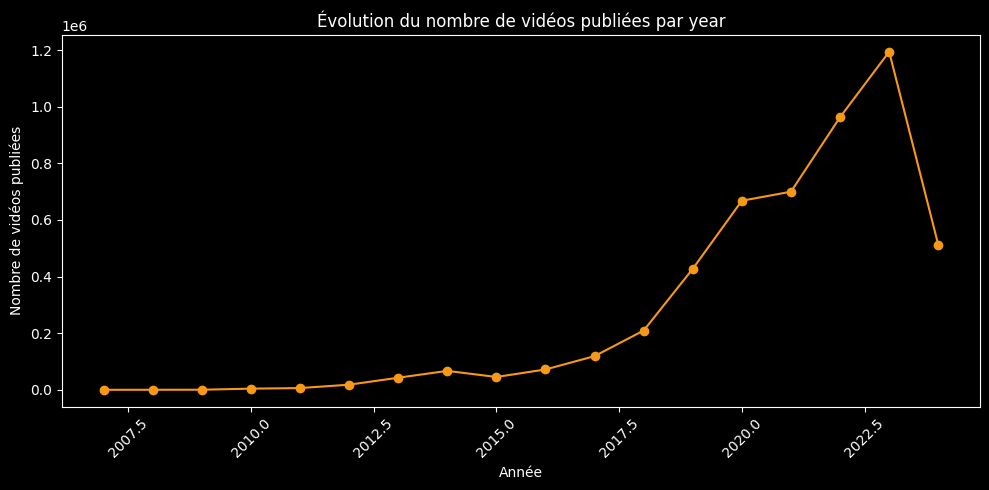

chemin vers fichier JSON : JSON_evolution/evolution_year_videos_periods.json


In [73]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


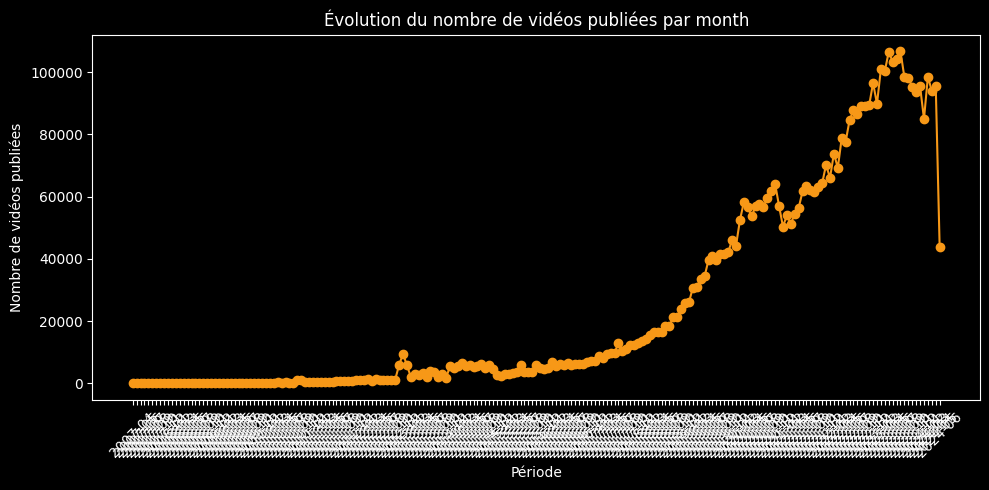

chemin vers fichier JSON : JSON_evolution/evolution_month_videos_periods.json


In [74]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


In [75]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


Aucune entrée fournie. Veuillez entrer une requête valide.


In [76]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


Aucune entrée fournie. Veuillez entrer une requête valide.


In [77]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


Aucune entrée fournie. Veuillez entrer une requête valide.


In [78]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


Aucune entrée fournie. Veuillez entrer une requête valide.


In [79]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


Aucune entrée fournie. Veuillez entrer une requête valide.


In [80]:
# Appel de la fonction pour traiter l'input et afficher les résultats
process_input(input("Enter your query (e.g., 'top views 5'): "))


Aucune entrée fournie. Veuillez entrer une requête valide.
